In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Make charts look nice for the thesis
sns.set_style("whitegrid")

In [60]:
# Load only the first sheet (main)

#df = pd.read_excel('UK2025Risk.J.xlsx')
#df = pd.read_excel('UK2024.J.xlsx')
#df = pd.read_excel('UK2023Risk.J.xlsx')
df = pd.read_excel('UK2022Risk.J.xlsx')
#df = pd.read_excel('UK2021Risk.J.xlsx')


# Check if you have all the statuses you need (active, cancelled, complete, etc.)
print("Statuses found in data:")
print(df['tender_status'].value_counts())

Statuses found in data:
tender_status
complete        15928
active           4611
planned          2462
cancelled         407
unsuccessful      167
planning           25
withdrawn           1
Name: count, dtype: int64


In [61]:
# --- FORCE CLEANING FOR 2022 ---

# 1. Define the only statuses we want to keep
# We strictly remove 'active', 'planned', 'planning' to match the other years
final_statuses = ['complete', 'cancelled', 'unsuccessful', 'withdrawn']

# 2. Apply the filter and OVERWRITE the dataframe
print(f"Row count before filter: {len(df)}")
df = df[df['tender_status'].isin(final_statuses)].copy()
print(f"Row count after filter:  {len(df)}")

# 3. Verify it worked
print("\nremaining statuses:")
print(df['tender_status'].value_counts())

Row count before filter: 24477
Row count after filter:  16503

remaining statuses:
tender_status
complete        15928
cancelled         407
unsuccessful      167
withdrawn           1
Name: count, dtype: int64


In [62]:
# Create a simple label for the Industry Sectors
# These are the standard CPV 'Divisions' Theo mentioned
sector_labels = {
    '45': 'Construction',
    '72': 'IT & Computer Services',
    '79': 'Consulting & Business',
    '85': 'Health & Social Work',
    '35': 'Security & Defense',
    '60': 'Transport'
}

# Extract the sector (first 2 digits) and apply the label
df['sector_code'] = df['tender_classification_id'].astype(str).str[:2]
# Only keep the standard CPV divisions, group rest as 'Other'
df['industry_label'] = df['sector_code'].map(sector_labels).fillna('Other')

# Add the 1/0 switches for these industries (One-Hot Encoding)
# This replaces the biased classification_id in the PCA
df = pd.concat([df, pd.get_dummies(df['industry_label'], prefix='is')], axis=1)

# Add your standard flags and dates
df['sme_flag'] = df['tender_suitability_sme'].map({True: 1, False: 0}).fillna(0)
df['accelerated_flag'] = df['tender_procedure_isAccelerated'].map({True: 1, False: 0}).fillna(0)
df['lead_time_days'] = (pd.to_datetime(df['tender_contractPeriod_startDate'], utc=True) - 
                        pd.to_datetime(df['date'], utc=True)).dt.days.fillna(0)

In [63]:
# Select the core numeric columns
# We'll handle the dummies carefully to keep the index aligned
X_cols = ['tender_value_amount', 'lead_time_days', 'sme_flag', 'accelerated_flag']
X = df[X_cols].copy()

# Add the industry dummies BEFORE dropping NaNs to keep indices synced
industry_dummies = pd.get_dummies(df['industry_label'], prefix='is')
X = pd.concat([X, industry_dummies], axis=1)

# CRITICAL FIX: Drop ANY row that has a NaN in any column
# This ensures the final matrix is perfectly clean for the PCA
X = X.dropna()

# Standardise: Mean=0, Std=1
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA()
pca_results = pca.fit_transform(X_Scaled)

# Check the signal strength (Fixed the string warning too)
print("Explained variance ratio (eigenvalues / Lambda):")
print(pca.explained_variance_ratio_)

Explained variance ratio (eigenvalues / Lambda):
[0.15667542 0.15230603 0.1042388  0.10288694 0.10082791 0.09367889
 0.09201777 0.0880111  0.08400621 0.02535093 0.        ]


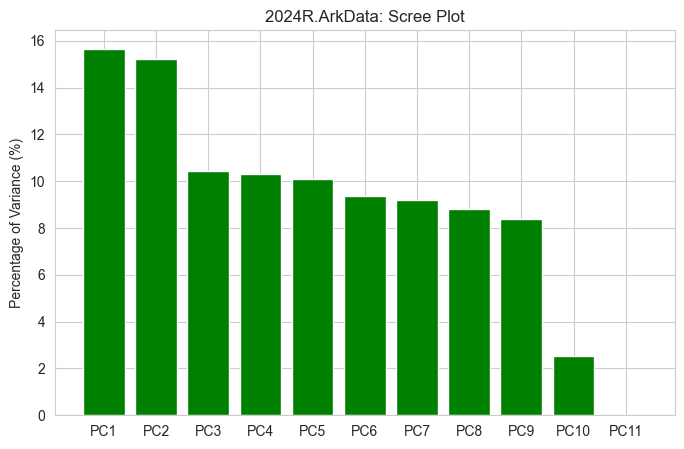

In [64]:
pc_labels = [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
variances = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(8, 5))
plt.bar(pc_labels, variances, color='green')
plt.ylabel('Percentage of Variance (%)')
plt.title('2024R.ArkData: Scree Plot')
plt.show()

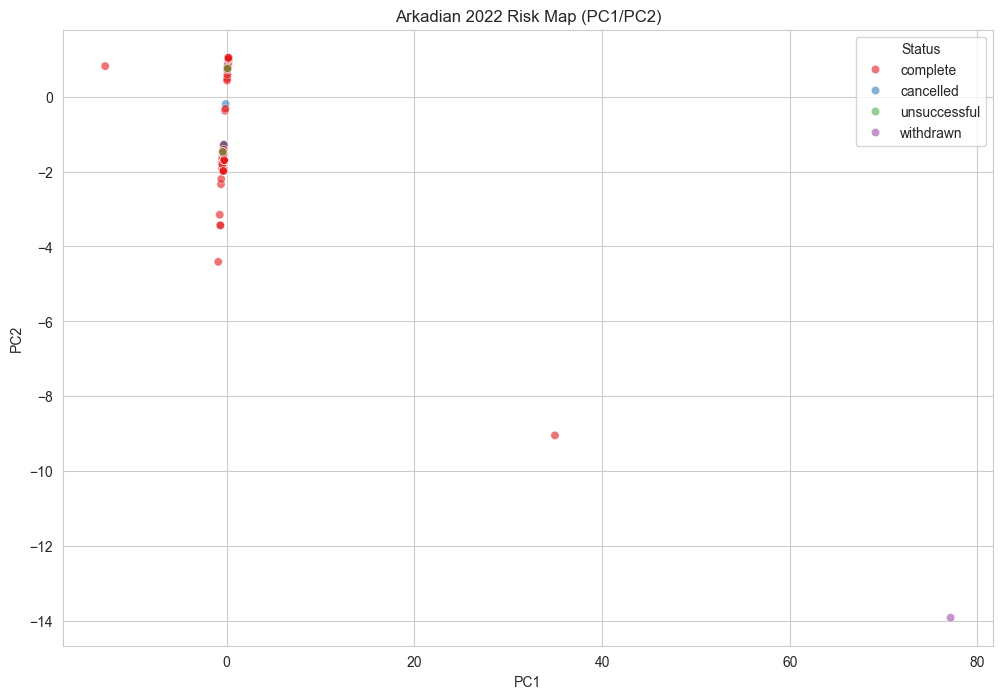

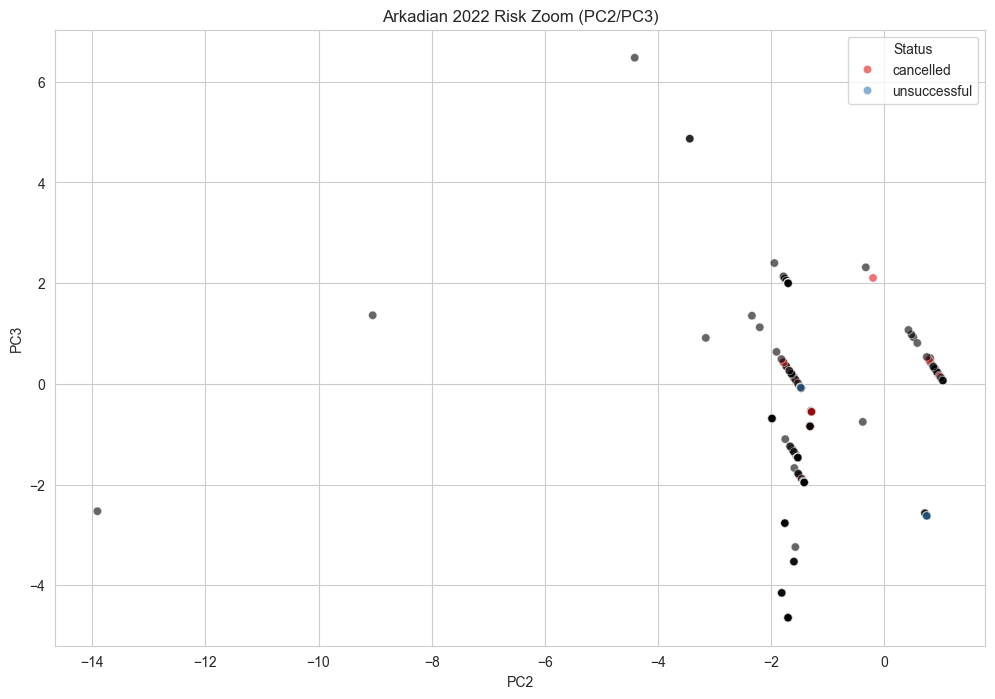

In [65]:
# --- PART A: Main Risk Map (PC1 vs PC2) ---
pc_map = pd.DataFrame(pca_results[:, :2], columns=['PC1', 'PC2'])

# FIX: Filter status to match only the 5,859 surviving rows
pc_map['Status'] = df.loc[X.index, 'tender_status'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pc_map, x='PC1', y='PC2', hue='Status', 
    hue_order=['complete', 'cancelled', 'unsuccessful', 'withdrawn'],
    palette='Set1', alpha=0.6
)
plt.title('Arkadian 2022 Risk Map (PC1/PC2)')
plt.show()

# --- PART B: Risk Zoom (PC2 vs PC3) ---
pc_deep_map = pd.DataFrame(pca_results[:, 1:3], columns=['PC2', 'PC3'])

# FIX: Again, filter status to match the PCA index
pc_deep_map['Status'] = df.loc[X.index, 'tender_status'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pc_deep_map, x='PC2', y='PC3', hue='Status', 
    hue_order=['cancelled', 'unsuccessful'],
    palette='Set1', alpha=0.6
)
plt.title('Arkadian 2022 Risk Zoom (PC2/PC3)')
plt.show()

In [67]:
# Create loadings table for all variables
# We use X.columns because that is the final table we sent to the PCA
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)], 
    index=X.columns
)

# Look at the recipe for PC2/3
print("-PC1 Drivers-")
print(loadings['PC1'].sort_values(ascending=False))


-PC1 Drivers-
lead_time_days               0.694877
sme_flag                     0.691619
is_Other                     0.149608
accelerated_flag            -0.012319
is_Security & Defense       -0.017301
tender_value_amount         -0.017793
is_Transport                -0.025455
is_IT & Computer Services   -0.045654
is_Health & Social Work     -0.048100
is_Consulting & Business    -0.069983
is_Construction             -0.075607
Name: PC1, dtype: float64


In [68]:
print("-PC2 Drivers-")
print(loadings['PC2'].sort_values(ascending=False))


-PC2 Drivers-
is_Other                     0.754518
accelerated_flag            -0.036338
is_Security & Defense       -0.075551
tender_value_amount         -0.075605
is_Transport                -0.111014
lead_time_days              -0.126604
sme_flag                    -0.145630
is_IT & Computer Services   -0.198714
is_Construction             -0.257870
is_Consulting & Business    -0.310220
is_Health & Social Work     -0.407649
Name: PC2, dtype: float64


In [69]:
print("-PC3 Drivers-")
print(loadings['PC3'].sort_values(ascending=False))


-PC3 Drivers-
is_Health & Social Work      0.687195
tender_value_amount          0.124824
is_Other                     0.037434
sme_flag                    -0.010810
is_Construction             -0.018879
lead_time_days              -0.032620
is_Security & Defense       -0.052570
is_Transport                -0.114881
accelerated_flag            -0.342093
is_IT & Computer Services   -0.425648
is_Consulting & Business    -0.441677
Name: PC3, dtype: float64
